# 1.9i: Bounding Boxes for the Local Neighborhood

From 1.9h we have 52 unique vectors (13 BH centroids + 39 singletons) forming an almost-complete graph.

**Question:** How big is the smallest hyperrectangle/hypercube that contains this entire structure?

**Method:**
1. Load the 52 unique vectors in uint16 representation
2. Compute per-dimension extents: `max - min` for each of 2,560 dimensions
3. Analyze the **bounding hyperrectangle**: side lengths in each dimension
4. Compute the **bounding hypercube**: max extent across all dimensions

**Expected result:** Most dimensions have extent 0 (all vectors identical), with ~20 "active" dimensions from 1.9c showing non-zero variation.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Active dimensions from 1.9c (for reference)
ACTIVE_DIMS = [216, 282, 322, 450, 993, 1008, 1149, 1155, 1272, 1382, 
               1403, 1435, 1487, 1564, 1763, 2012, 2040, 2079, 2143, 2479]

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import Counter

## Load Data

In [3]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")
print(f"Dtype: {W_bf16.dtype}")

Loaded W: torch.Size([151936, 2560])
Dtype: torch.bfloat16


In [4]:
# Load neighborhood data from 1.9g
nbhd_path = Path(f"../tensors/{MODEL_NAME}/1.9g_local_neighborhood.safetensors")
nbhd_data = load_file(nbhd_path)

full_neighborhood_token_ids = nbhd_data["full_neighborhood_token_ids"].to(torch.int64)
n_full_neighborhood = nbhd_data["n_full_neighborhood"].item()

print(f"\nLoaded neighborhood: {n_full_neighborhood:,} tokens")


Loaded neighborhood: 2,139 tokens


## Extract Unique Vectors

In [5]:
print("\nExtracting unique vectors...\n")

# Get all vectors in the neighborhood
neighborhood_vectors_bf16 = W_bf16[full_neighborhood_token_ids]

# Convert to uint16 for exact comparison
neighborhood_vectors_uint16 = neighborhood_vectors_bf16.cpu().view(torch.uint16).numpy()

# Find unique vectors
unique_vectors = np.unique(neighborhood_vectors_uint16, axis=0)
n_unique = len(unique_vectors)

print(f"✓ Found {n_unique} unique vectors")
print(f"  From {len(full_neighborhood_token_ids):,} total tokens")
print(f"  Shape: {unique_vectors.shape}")


Extracting unique vectors...

✓ Found 52 unique vectors
  From 2,139 total tokens
  Shape: (52, 2560)


## Compute Bounding Hyperrectangle

In [6]:
print("\n" + "=" * 100)
print("BOUNDING HYPERRECTANGLE")
print("=" * 100)
print()

# Compute min and max in each dimension
mins_per_dim = unique_vectors.min(axis=0)
maxs_per_dim = unique_vectors.max(axis=0)
extents_per_dim = maxs_per_dim - mins_per_dim

print(f"Computed extents for all {len(extents_per_dim):,} dimensions")
print()

# Count how many dimensions have each extent
extent_counts = Counter(extents_per_dim)
sorted_extents = sorted(extent_counts.items())

print("Extent distribution (extent: count):")
for extent, count in sorted_extents:
    print(f"  {extent:3d}: {count:4d} dimensions ({100*count/len(extents_per_dim):5.2f}%)")

print()

# Identify dimensions with non-zero extent
active_dims_by_extent = np.where(extents_per_dim > 0)[0]
n_active_dims = len(active_dims_by_extent)

print(f"Dimensions with variation: {n_active_dims}")
print(f"Dimensions with no variation: {len(extents_per_dim) - n_active_dims}")
print()

# Show the active dimensions and their extents
if n_active_dims > 0:
    print(f"Active dimensions (extent > 0):")
    for dim in active_dims_by_extent:
        extent = extents_per_dim[dim]
        min_val = mins_per_dim[dim]
        max_val = maxs_per_dim[dim]
        in_known_active = "✓" if dim in ACTIVE_DIMS else " "
        print(f"  {in_known_active} Dim {dim:4d}: extent={extent:3d}  [{min_val:5d}, {max_val:5d}]")

print()

# Check if active dims match 1.9c's known active dims
active_dims_set = set(active_dims_by_extent)
known_active_set = set(ACTIVE_DIMS)

if active_dims_set == known_active_set:
    print("✓ Active dimensions EXACTLY MATCH 1.9c's 20 active dimensions")
elif active_dims_set.issubset(known_active_set):
    print(f"~ Active dimensions are a SUBSET of 1.9c's active dimensions")
    print(f"  Missing: {known_active_set - active_dims_set}")
elif known_active_set.issubset(active_dims_set):
    print(f"~ Active dimensions are a SUPERSET of 1.9c's active dimensions")
    print(f"  Additional: {active_dims_set - known_active_set}")
else:
    print(f"⚠ Active dimensions DIFFER from 1.9c")
    print(f"  Overlap: {len(active_dims_set & known_active_set)} dimensions")
    print(f"  Only in this analysis: {active_dims_set - known_active_set}")
    print(f"  Only in 1.9c: {known_active_set - active_dims_set}")


BOUNDING HYPERRECTANGLE

Computed extents for all 2,560 dimensions

Extent distribution (extent: count):
    0: 2484 dimensions (97.03%)
    1:   50 dimensions ( 1.95%)
    2:   11 dimensions ( 0.43%)
    3:    6 dimensions ( 0.23%)
    4:    1 dimensions ( 0.04%)
    7:    1 dimensions ( 0.04%)
    8:    2 dimensions ( 0.08%)
    9:    2 dimensions ( 0.08%)
   27:    1 dimensions ( 0.04%)
   32:    1 dimensions ( 0.04%)
   55:    1 dimensions ( 0.04%)

Dimensions with variation: 76
Dimensions with no variation: 2484

Active dimensions (extent > 0):
    Dim   61: extent=  1  [47525, 47526]
    Dim   74: extent=  1  [47567, 47568]
    Dim   82: extent=  1  [15315, 15316]
  ✓ Dim  216: extent=  1  [47839, 47840]
  ✓ Dim  282: extent=  1  [47976, 47977]
  ✓ Dim  322: extent=  2  [15199, 15201]
    Dim  371: extent=  1  [47522, 47523]
    Dim  381: extent=  1  [14665, 14666]
    Dim  413: extent=  4  [14376, 14380]
    Dim  414: extent=  2  [47415, 47417]
  ✓ Dim  450: extent=  1  [47444,

## Compute Bounding Hypercube

In [7]:
print("\n" + "=" * 100)
print("BOUNDING HYPERCUBE")
print("=" * 100)
print()

# Maximum extent across all dimensions
max_extent = extents_per_dim.max()
max_extent_dim = extents_per_dim.argmax()

print(f"Maximum extent: {max_extent} uint16 steps")
print(f"  Occurs in dimension {max_extent_dim}")
print(f"  Range in that dimension: [{mins_per_dim[max_extent_dim]}, {maxs_per_dim[max_extent_dim]}]")
print()

print(f"Minimum bounding hypercube:")
print(f"  Side length: {max_extent} uint16 steps")
print(f"  Number of dimensions: {len(extents_per_dim):,}")
print(f"  Volume: {max_extent}^{len(extents_per_dim)} lattice cells (astronomically large)")
print()

print(f"Interpretation:")
print(f"  The entire 52-vector structure fits within a {max_extent}×{max_extent}×...×{max_extent} hypercube")
print(f"  in uint16 lattice coordinates across {len(extents_per_dim):,} dimensions.")
print()

# Density estimate (very rough)
if max_extent > 0:
    # Volume of the hyperrectangle (product of all extents, treating 0 as 1)
    nonzero_extents = extents_per_dim[extents_per_dim > 0]
    if len(nonzero_extents) > 0:
        # Volume is product of all non-zero extents
        volume_rect = np.prod(nonzero_extents.astype(np.float64))
        density = n_unique / volume_rect
        print(f"Hyperrectangle volume (non-zero dims only): {volume_rect:.2e} lattice cells")
        print(f"Density: {density:.2e} vectors per lattice cell")
        print(f"  ({100*density:.6f}% occupancy)")


BOUNDING HYPERCUBE

Maximum extent: 55 uint16 steps
  Occurs in dimension 1008
  Range in that dimension: [46519, 46574]

Minimum bounding hypercube:
  Side length: 55 uint16 steps
  Number of dimensions: 2,560
  Volume: 55^2560 lattice cells (astronomically large)

Interpretation:
  The entire 52-vector structure fits within a 55×55×...×55 hypercube
  in uint16 lattice coordinates across 2,560 dimensions.

Hyperrectangle volume (non-zero dims only): 1.03e+16 lattice cells
Density: 5.05e-15 vectors per lattice cell
  (0.000000% occupancy)


## Visualizations


Creating visualizations...



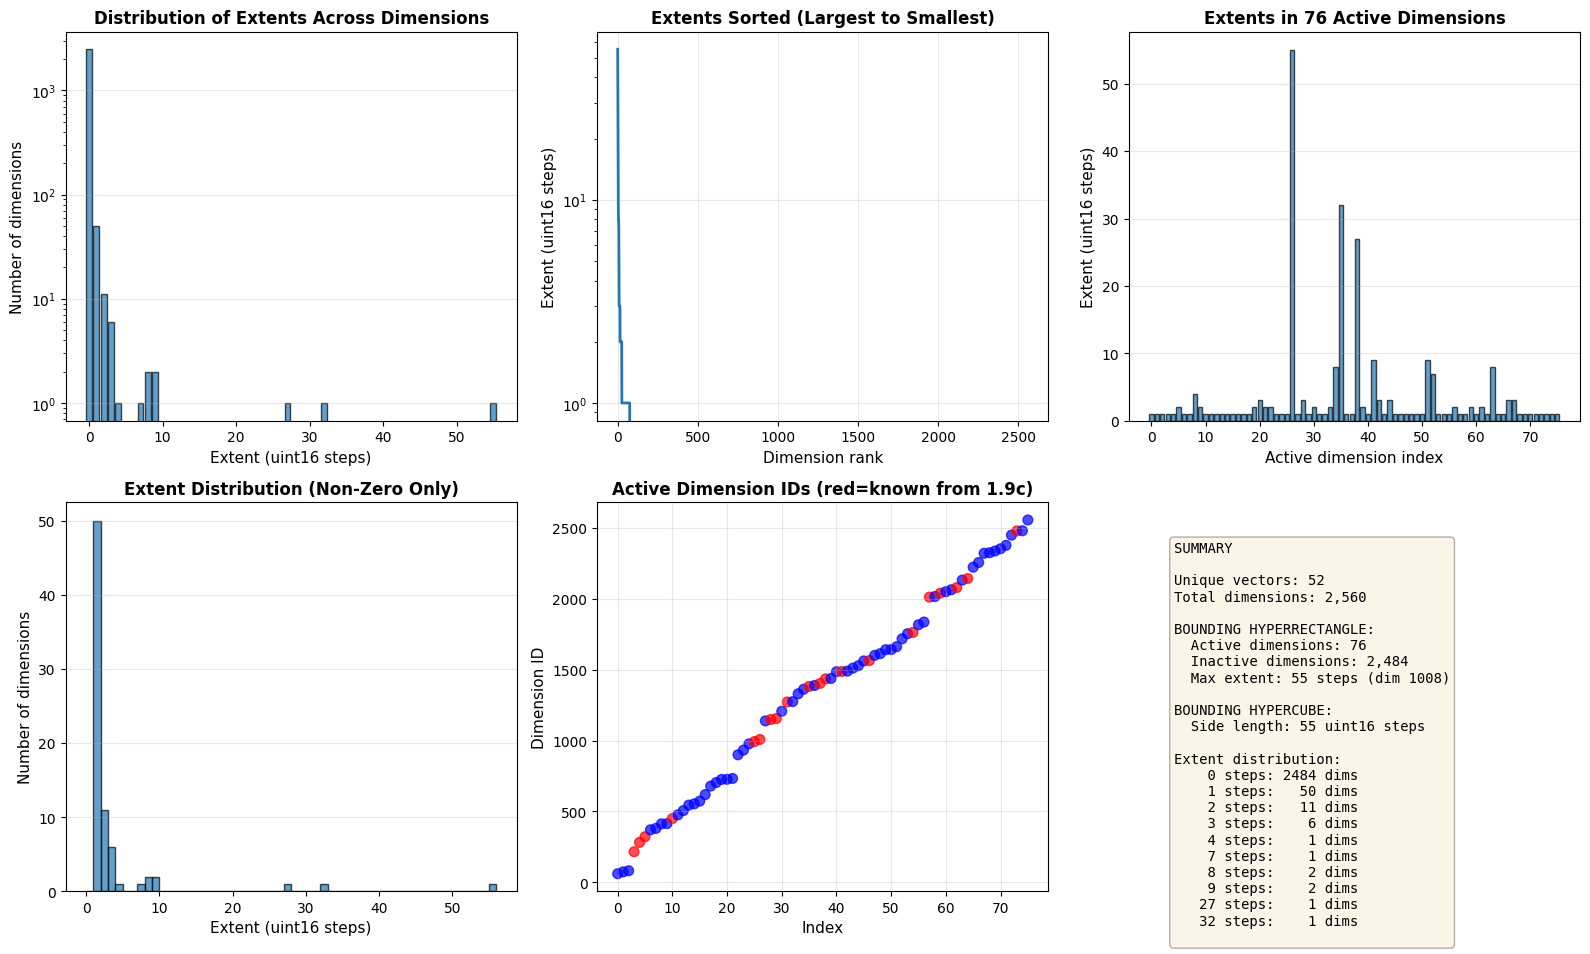

✓ Visualizations complete


In [8]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=(16, 10), dpi=100)

# 1. Extent distribution (log scale)
ax1 = plt.subplot(2, 3, 1)
extent_values, extent_counts_list = zip(*sorted(extent_counts.items()))
ax1.bar(extent_values, extent_counts_list, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Extent (uint16 steps)', fontsize=11)
ax1.set_ylabel('Number of dimensions', fontsize=11)
ax1.set_title('Distribution of Extents Across Dimensions', fontsize=12, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# 2. Cumulative extent plot
ax2 = plt.subplot(2, 3, 2)
sorted_extents_arr = np.sort(extents_per_dim)[::-1]
ax2.plot(range(len(sorted_extents_arr)), sorted_extents_arr, linewidth=2)
ax2.set_xlabel('Dimension rank', fontsize=11)
ax2.set_ylabel('Extent (uint16 steps)', fontsize=11)
ax2.set_title('Extents Sorted (Largest to Smallest)', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(alpha=0.3)

# 3. Active dimensions only (bar chart)
ax3 = plt.subplot(2, 3, 3)
if n_active_dims > 0:
    active_extents = extents_per_dim[active_dims_by_extent]
    ax3.bar(range(n_active_dims), active_extents, edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Active dimension index', fontsize=11)
    ax3.set_ylabel('Extent (uint16 steps)', fontsize=11)
    ax3.set_title(f'Extents in {n_active_dims} Active Dimensions', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No active dimensions', ha='center', va='center')
    ax3.set_title('Active Dimensions', fontsize=12, fontweight='bold')

# 4. Extent histogram (linear scale, zoomed)
ax4 = plt.subplot(2, 3, 4)
nonzero_extents_list = extents_per_dim[extents_per_dim > 0]
if len(nonzero_extents_list) > 0:
    ax4.hist(nonzero_extents_list, bins=range(0, max(nonzero_extents_list)+2), 
             edgecolor='black', alpha=0.7)
    ax4.set_xlabel('Extent (uint16 steps)', fontsize=11)
    ax4.set_ylabel('Number of dimensions', fontsize=11)
    ax4.set_title('Extent Distribution (Non-Zero Only)', fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'All extents are zero', ha='center', va='center')
    ax4.set_title('Extent Distribution', fontsize=12, fontweight='bold')

# 5. Active dimension IDs
ax5 = plt.subplot(2, 3, 5)
if n_active_dims > 0:
    # Mark which active dims are in ACTIVE_DIMS
    colors = ['red' if d in ACTIVE_DIMS else 'blue' for d in active_dims_by_extent]
    ax5.scatter(range(n_active_dims), active_dims_by_extent, c=colors, s=50, alpha=0.7)
    ax5.set_xlabel('Index', fontsize=11)
    ax5.set_ylabel('Dimension ID', fontsize=11)
    ax5.set_title('Active Dimension IDs (red=known from 1.9c)', fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No active dimensions', ha='center', va='center')
    ax5.set_title('Active Dimension IDs', fontsize=12, fontweight='bold')

# 6. Summary text box
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""SUMMARY

Unique vectors: {n_unique}
Total dimensions: {len(extents_per_dim):,}

BOUNDING HYPERRECTANGLE:
  Active dimensions: {n_active_dims}
  Inactive dimensions: {len(extents_per_dim) - n_active_dims:,}
  Max extent: {max_extent} steps (dim {max_extent_dim})

BOUNDING HYPERCUBE:
  Side length: {max_extent} uint16 steps
  
Extent distribution:
"""
for extent, count in sorted(extent_counts.items())[:10]:
    summary_text += f"  {extent:3d} steps: {count:4d} dims\n"

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [9]:
print("\n" + "=" * 100)
print("SUMMARY: BOUNDING BOXES FOR LOCAL NEIGHBORHOOD")
print("=" * 100)
print()

print(f"Structure: {n_unique} unique vectors in {len(extents_per_dim):,}-dimensional uint16 lattice")
print()

print(f"BOUNDING HYPERRECTANGLE:")
print(f"  Dimensions with variation: {n_active_dims}")
print(f"  Dimensions with no variation: {len(extents_per_dim) - n_active_dims:,}")
print(f"  Largest extent: {max_extent} uint16 steps (dimension {max_extent_dim})")
print()

print(f"BOUNDING HYPERCUBE:")
print(f"  Side length: {max_extent} uint16 steps")
print(f"  The entire structure fits in a {max_extent}×{max_extent}×...×{max_extent} hypercube")
print()

print("Key findings:")
print()

if n_active_dims == len(ACTIVE_DIMS) and active_dims_set == known_active_set:
    print(f"  ✓ EXACTLY {n_active_dims} ACTIVE DIMENSIONS")
    print("    Matches 1.9c's analysis of black hole variation.")
    print("    The 52 vectors vary in the same dimensions as the 13 BH centroids.")
elif n_active_dims < len(ACTIVE_DIMS):
    print(f"  ~ FEWER ACTIVE DIMENSIONS THAN EXPECTED ({n_active_dims} vs {len(ACTIVE_DIMS)})")
    print("    Some dimensions that vary among BHs are constant in this neighborhood.")
else:
    print(f"  ⚠ MORE ACTIVE DIMENSIONS THAN EXPECTED ({n_active_dims} vs {len(ACTIVE_DIMS)})")
    print("    Singleton vectors vary in dimensions where BH centroids are constant!")

print()

if max_extent <= 10:
    print(f"  ✓ EXTREMELY COMPACT STRUCTURE")
    print(f"    Maximum span of {max_extent} steps is tiny compared to bfloat16 mantissa range (~128).")
    print("    All 52 vectors are packed into a minuscule corner of the exponent hypercube.")
elif max_extent <= 50:
    print(f"  ✓ COMPACT STRUCTURE")
    print(f"    Maximum span of {max_extent} steps fits well within bfloat16 mantissa range (~128).")
    print("    The structure occupies a small fraction of the available lattice.")
else:
    print(f"  ~ MODERATE EXTENT")
    print(f"    Maximum span of {max_extent} steps approaches the bfloat16 mantissa range (~128).")
    print("    The structure spreads across a significant portion of the exponent hypercube.")

print()
print("=" * 100)


SUMMARY: BOUNDING BOXES FOR LOCAL NEIGHBORHOOD

Structure: 52 unique vectors in 2,560-dimensional uint16 lattice

BOUNDING HYPERRECTANGLE:
  Dimensions with variation: 76
  Dimensions with no variation: 2,484
  Largest extent: 55 uint16 steps (dimension 1008)

BOUNDING HYPERCUBE:
  Side length: 55 uint16 steps
  The entire structure fits in a 55×55×...×55 hypercube

Key findings:

  ⚠ MORE ACTIVE DIMENSIONS THAN EXPECTED (76 vs 20)
    Singleton vectors vary in dimensions where BH centroids are constant!

  ~ MODERATE EXTENT
    Maximum span of 55 steps approaches the bfloat16 mantissa range (~128).
    The structure spreads across a significant portion of the exponent hypercube.

